## Implementation of Variational AutoEncoder (VAE)

> VAE를 구현하면서 중요하게 생각한 point들은 다음과 같다.

- 1) cuda tensor에서 numpy array 변환 시 오류: loss function, reparameterize 함수 안의 numpy를 torch.exp() or .pow() 등으로 변환
- 2) Decoder output을 x_hat만 반환할 경우 loss function 계산시 어려우므로 중간 단계인 Encoder에서 나온 output까지 같이 반환
- 3) 0 또는 1의 binary value를 target이 가지고 있는 binary classification 문제가 아니어도 [0, 1] 사이의 value를 가질 경우 BCE Loss 사용이 가능

In [1]:
!pip install tqdm

In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [4]:
batch_size = 64
epochs = 100

input_dim = 28 * 28
latent_dim = 128
lr = 1e-3

### 1. Load Dataset

In [5]:
pip install "numpy<2.0" 

Note: you may need to restart the kernel to use updated packages.


In [6]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

mnist_transform = transforms.Compose([transforms.ToTensor()])

kwargs = {"num_workers": 1, "pin_memory": True} if torch.cuda.is_available() else {}

train_dataset = MNIST(
    root="./data", train=True, download=True, transform=mnist_transform
)
test_dataset = MNIST(
    root="./data", train=False, download=True, transform=mnist_transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [7]:
! nvidia-smi

Mon Jul 15 12:48:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090 Ti   WDDM  |   00000000:07:00.0  On |                  Off |
|  0%   49C    P8             38W /  480W |    1000MiB /  24564MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 2. Define VAE Model

In [9]:
"""
Simple implementation of a Gaussian MLP variational autoencoder in PyTorch.
"""


class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()

        def block(in_dim, out_dim):
            return nn.Sequential(
                nn.Linear(in_dim, out_dim), nn.LayerNorm(out_dim), nn.LeakyReLU(0.2)
            )

        self.downlayers = nn.Sequential(
            *block(input_dim, latent_dim * 2),
            *block(latent_dim * 2, latent_dim * 2),
        )

        self.mean = nn.Linear(latent_dim * 2, latent_dim)
        self.logvar = nn.Linear(
            latent_dim * 2, latent_dim
        )  # Encoder produces mean and log variance of the normal distribution

    def forward(self, x):
        mean = self.mean(self.downlayers(x))
        logvar = self.logvar(self.downlayers(x))

        return mean, logvar

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()

        def block(in_dim, out_dim):
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.LayerNorm(out_dim),
                nn.LeakyReLU(0.2),
            )

        self.uplayers = nn.Sequential(
            *block(latent_dim, latent_dim * 2),
            *block(latent_dim * 2, latent_dim * 2),
        )

        self.reconstruction = nn.Linear(latent_dim * 2, output_dim)

    def forward(self, x):
        x = self.uplayers(x)
        x = self.reconstruction(x)
        x_hat = torch.sigmoid(
            x
        )  # Sigmoid activation for Binary Cross Entropy Loss (0, 1)
        return x_hat

In [11]:
def reparameterize(mean, logvar):
    eps = torch.randn_like(mean)
    std = torch.exp(logvar / 2)
    z = mean + std * eps
    return z

In [12]:
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def forward(self, x):
        mean, logvar = self.Encoder(x)
        z = reparameterize(mean, logvar)
        x_hat = self.Decoder(z)
        return x_hat, mean, logvar

In [13]:
encoder = Encoder(input_dim, latent_dim).to(device)
decoder = Decoder(latent_dim, input_dim).to(device)

model = VAE(encoder, decoder).to(device)

### 3. Define Loss Function (reprod, loss) and optimizer

In [14]:
def loss_function(x, x_hat, mean, logvar):
    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
    regularization_loss = (1 / 2) * torch.sum(logvar.exp() + mean**2 - logvar - 1)

    return reconstruction_loss + regularization_loss


optimizer = optim.Adam(model.parameters(), lr=lr)

### 4. Train Variational AutoEncoder (VAE)

In [15]:
print("Start training VAE...")

model.train()
for epoch in range(epochs):
    overall_loss = 0
    for idx, (x, _) in enumerate(tqdm(train_loader)):
        x = x.view(-1, input_dim).to(device)
        optimizer.zero_grad()
        x_hat, mean, logvar = model(x)
        loss = loss_function(x, x_hat, mean, logvar)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Average Loss: {overall_loss / len(train_loader.dataset)}")

print("Training finished!")

Start training VAE...


100%|██████████| 938/938 [00:06<00:00, 136.15it/s]


Epoch 1, Average Loss: 169.81259986165364


100%|██████████| 938/938 [00:06<00:00, 143.90it/s]


Epoch 2, Average Loss: 126.36157364095052


100%|██████████| 938/938 [00:06<00:00, 141.36it/s]


Epoch 3, Average Loss: 116.75265151367188


100%|██████████| 938/938 [00:06<00:00, 139.84it/s]


Epoch 4, Average Loss: 112.45649479573568


100%|██████████| 938/938 [00:06<00:00, 144.00it/s]


Epoch 5, Average Loss: 109.86577363688151


100%|██████████| 938/938 [00:06<00:00, 140.96it/s]


Epoch 6, Average Loss: 108.13855161132813


100%|██████████| 938/938 [00:06<00:00, 144.55it/s]


Epoch 7, Average Loss: 106.85389527180989


100%|██████████| 938/938 [00:06<00:00, 144.35it/s]


Epoch 8, Average Loss: 105.88468199869791


100%|██████████| 938/938 [00:06<00:00, 139.63it/s]


Epoch 9, Average Loss: 105.10414119466145


100%|██████████| 938/938 [00:06<00:00, 138.10it/s]


Epoch 10, Average Loss: 104.38940498046875


100%|██████████| 938/938 [00:06<00:00, 137.37it/s]


Epoch 11, Average Loss: 103.76639648844402


100%|██████████| 938/938 [00:06<00:00, 137.94it/s]


Epoch 12, Average Loss: 103.25487443847656


100%|██████████| 938/938 [00:06<00:00, 138.31it/s]


Epoch 13, Average Loss: 102.80709700520833


100%|██████████| 938/938 [00:06<00:00, 139.53it/s]


Epoch 14, Average Loss: 102.41871746419271


100%|██████████| 938/938 [00:06<00:00, 138.41it/s]


Epoch 15, Average Loss: 102.10810836588541


100%|██████████| 938/938 [00:06<00:00, 143.35it/s]


Epoch 16, Average Loss: 101.81983390299479


100%|██████████| 938/938 [00:06<00:00, 141.16it/s]


Epoch 17, Average Loss: 101.55115199788412


100%|██████████| 938/938 [00:06<00:00, 138.02it/s]


Epoch 18, Average Loss: 101.34713489583334


100%|██████████| 938/938 [00:06<00:00, 137.45it/s]


Epoch 19, Average Loss: 101.15395224609375


100%|██████████| 938/938 [00:07<00:00, 133.69it/s]


Epoch 20, Average Loss: 100.92753521321615


100%|██████████| 938/938 [00:06<00:00, 140.48it/s]


Epoch 21, Average Loss: 100.74501733398438


100%|██████████| 938/938 [00:06<00:00, 142.03it/s]


Epoch 22, Average Loss: 100.6021073038737


100%|██████████| 938/938 [00:06<00:00, 142.28it/s]


Epoch 23, Average Loss: 100.43927740885417


100%|██████████| 938/938 [00:06<00:00, 143.97it/s]


Epoch 24, Average Loss: 100.25101071370443


100%|██████████| 938/938 [00:06<00:00, 143.71it/s]


Epoch 25, Average Loss: 100.09358371988932


100%|██████████| 938/938 [00:06<00:00, 138.25it/s]


Epoch 26, Average Loss: 100.0122190266927


100%|██████████| 938/938 [00:07<00:00, 134.00it/s]


Epoch 27, Average Loss: 99.85069192708333


100%|██████████| 938/938 [00:06<00:00, 138.61it/s]


Epoch 28, Average Loss: 99.74086364746094


100%|██████████| 938/938 [00:07<00:00, 128.84it/s]


Epoch 29, Average Loss: 99.61378508707682


100%|██████████| 938/938 [00:07<00:00, 133.02it/s]


Epoch 30, Average Loss: 99.50106501464843


100%|██████████| 938/938 [00:06<00:00, 139.38it/s]


Epoch 31, Average Loss: 99.37336234944661


100%|██████████| 938/938 [00:06<00:00, 137.61it/s]


Epoch 32, Average Loss: 99.29236135253906


100%|██████████| 938/938 [00:06<00:00, 139.78it/s]


Epoch 33, Average Loss: 99.1419517211914


100%|██████████| 938/938 [00:06<00:00, 141.33it/s]


Epoch 34, Average Loss: 99.07932611490885


100%|██████████| 938/938 [00:06<00:00, 140.58it/s]


Epoch 35, Average Loss: 99.0170905110677


100%|██████████| 938/938 [00:06<00:00, 139.68it/s]


Epoch 36, Average Loss: 98.9166044921875


100%|██████████| 938/938 [00:06<00:00, 140.78it/s]


Epoch 37, Average Loss: 98.83310059407552


100%|██████████| 938/938 [00:06<00:00, 141.71it/s]


Epoch 38, Average Loss: 98.80228320719401


100%|██████████| 938/938 [00:06<00:00, 139.99it/s]


Epoch 39, Average Loss: 98.66906632080078


100%|██████████| 938/938 [00:06<00:00, 141.08it/s]


Epoch 40, Average Loss: 98.60258662109375


100%|██████████| 938/938 [00:06<00:00, 142.04it/s]


Epoch 41, Average Loss: 98.57687121582032


100%|██████████| 938/938 [00:06<00:00, 142.13it/s]


Epoch 42, Average Loss: 98.45320938313802


100%|██████████| 938/938 [00:06<00:00, 142.30it/s]


Epoch 43, Average Loss: 98.36896376953125


100%|██████████| 938/938 [00:06<00:00, 140.28it/s]


Epoch 44, Average Loss: 98.3395578125


100%|██████████| 938/938 [00:06<00:00, 141.47it/s]


Epoch 45, Average Loss: 98.25219250895182


100%|██████████| 938/938 [00:06<00:00, 142.44it/s]


Epoch 46, Average Loss: 98.22364650065104


100%|██████████| 938/938 [00:06<00:00, 144.80it/s]


Epoch 47, Average Loss: 98.13926313476563


100%|██████████| 938/938 [00:06<00:00, 141.16it/s]


Epoch 48, Average Loss: 98.07484997558593


100%|██████████| 938/938 [00:06<00:00, 144.20it/s]


Epoch 49, Average Loss: 98.01665641276041


100%|██████████| 938/938 [00:06<00:00, 141.46it/s]


Epoch 50, Average Loss: 97.98507861328125


100%|██████████| 938/938 [00:06<00:00, 140.87it/s]


Epoch 51, Average Loss: 97.95218810221354


100%|██████████| 938/938 [00:06<00:00, 142.33it/s]


Epoch 52, Average Loss: 97.87940819905599


100%|██████████| 938/938 [00:06<00:00, 144.28it/s]


Epoch 53, Average Loss: 97.79954691975911


100%|██████████| 938/938 [00:06<00:00, 142.83it/s]


Epoch 54, Average Loss: 97.77145172526042


100%|██████████| 938/938 [00:06<00:00, 143.78it/s]


Epoch 55, Average Loss: 97.73480854492188


100%|██████████| 938/938 [00:06<00:00, 142.95it/s]


Epoch 56, Average Loss: 97.68656709798177


100%|██████████| 938/938 [00:06<00:00, 142.10it/s]


Epoch 57, Average Loss: 97.65349217936198


100%|██████████| 938/938 [00:06<00:00, 142.59it/s]


Epoch 58, Average Loss: 97.57615327962239


100%|██████████| 938/938 [00:06<00:00, 143.13it/s]


Epoch 59, Average Loss: 97.55735372721354


100%|██████████| 938/938 [00:06<00:00, 144.26it/s]


Epoch 60, Average Loss: 97.50451849772135


100%|██████████| 938/938 [00:06<00:00, 143.29it/s]


Epoch 61, Average Loss: 97.44484783935548


100%|██████████| 938/938 [00:06<00:00, 145.01it/s]


Epoch 62, Average Loss: 97.42523083496094


100%|██████████| 938/938 [00:06<00:00, 143.70it/s]


Epoch 63, Average Loss: 97.39875137532552


100%|██████████| 938/938 [00:06<00:00, 142.98it/s]


Epoch 64, Average Loss: 97.35549646809896


100%|██████████| 938/938 [00:06<00:00, 143.43it/s]


Epoch 65, Average Loss: 97.30511923014323


100%|██████████| 938/938 [00:06<00:00, 142.29it/s]


Epoch 66, Average Loss: 97.27278359375


100%|██████████| 938/938 [00:06<00:00, 143.11it/s]


Epoch 67, Average Loss: 97.21925476074219


100%|██████████| 938/938 [00:06<00:00, 143.66it/s]


Epoch 68, Average Loss: 97.1849201904297


100%|██████████| 938/938 [00:06<00:00, 142.56it/s]


Epoch 69, Average Loss: 97.16770036621094


100%|██████████| 938/938 [00:06<00:00, 141.11it/s]


Epoch 70, Average Loss: 97.13947362467448


100%|██████████| 938/938 [00:06<00:00, 140.12it/s]


Epoch 71, Average Loss: 97.08953076578776


100%|██████████| 938/938 [00:06<00:00, 140.98it/s]


Epoch 72, Average Loss: 97.06766970214844


100%|██████████| 938/938 [00:06<00:00, 138.57it/s]


Epoch 73, Average Loss: 97.00134457194011


100%|██████████| 938/938 [00:06<00:00, 139.07it/s]


Epoch 74, Average Loss: 96.99733797607422


100%|██████████| 938/938 [00:06<00:00, 137.93it/s]


Epoch 75, Average Loss: 96.93057413330078


100%|██████████| 938/938 [00:06<00:00, 141.94it/s]


Epoch 76, Average Loss: 96.94250372721355


100%|██████████| 938/938 [00:06<00:00, 142.56it/s]


Epoch 77, Average Loss: 96.9000443359375


100%|██████████| 938/938 [00:06<00:00, 142.88it/s]


Epoch 78, Average Loss: 96.87644079182942


100%|██████████| 938/938 [00:06<00:00, 143.55it/s]


Epoch 79, Average Loss: 96.85860685221354


100%|██████████| 938/938 [00:06<00:00, 143.21it/s]


Epoch 80, Average Loss: 96.8018865641276


100%|██████████| 938/938 [00:06<00:00, 142.85it/s]


Epoch 81, Average Loss: 96.78341016031901


100%|██████████| 938/938 [00:06<00:00, 141.32it/s]


Epoch 82, Average Loss: 96.7576255045573


100%|██████████| 938/938 [00:06<00:00, 140.49it/s]


Epoch 83, Average Loss: 96.7173328531901


100%|██████████| 938/938 [00:06<00:00, 141.88it/s]


Epoch 84, Average Loss: 96.6865196858724


100%|██████████| 938/938 [00:06<00:00, 141.60it/s]


Epoch 85, Average Loss: 96.67092146809895


100%|██████████| 938/938 [00:06<00:00, 140.38it/s]


Epoch 86, Average Loss: 96.6807544108073


100%|██████████| 938/938 [00:06<00:00, 140.89it/s]


Epoch 87, Average Loss: 96.64683924560546


100%|██████████| 938/938 [00:06<00:00, 140.70it/s]


Epoch 88, Average Loss: 96.58468251546223


100%|██████████| 938/938 [00:06<00:00, 142.70it/s]


Epoch 89, Average Loss: 96.54948326416016


100%|██████████| 938/938 [00:06<00:00, 137.10it/s]


Epoch 90, Average Loss: 96.55106658121744


100%|██████████| 938/938 [00:06<00:00, 137.66it/s]


Epoch 91, Average Loss: 96.53633147786458


100%|██████████| 938/938 [00:06<00:00, 139.56it/s]


Epoch 92, Average Loss: 96.50857005615234


100%|██████████| 938/938 [00:06<00:00, 140.55it/s]


Epoch 93, Average Loss: 96.46935013834636


100%|██████████| 938/938 [00:06<00:00, 135.87it/s]


Epoch 94, Average Loss: 96.46407879231771


100%|██████████| 938/938 [00:06<00:00, 141.79it/s]


Epoch 95, Average Loss: 96.44036030680338


100%|██████████| 938/938 [00:06<00:00, 142.61it/s]


Epoch 96, Average Loss: 96.43564673665365


100%|██████████| 938/938 [00:06<00:00, 141.83it/s]


Epoch 97, Average Loss: 96.38766118570963


100%|██████████| 938/938 [00:06<00:00, 139.49it/s]


Epoch 98, Average Loss: 96.35980487874349


100%|██████████| 938/938 [00:06<00:00, 139.32it/s]


Epoch 99, Average Loss: 96.32969021402995


100%|██████████| 938/938 [00:06<00:00, 137.38it/s]

Epoch 100, Average Loss: 96.34567482096354
Training finished!


### 5. Generate images from test dataset

In [16]:
model.eval()

with torch.no_grad():
    for idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(-1, input_dim).to(device)
        x_hat, _, _ = model(x)

        if idx == 0:
            break  # Only visualize the first batch of the test set

    x = x.view(-1, 1, 28, 28).cpu().numpy()
    x_hat = x_hat.view(-1, 1, 28, 28).cpu().numpy()

  0%|          | 0/157 [00:02<?, ?it/s]


In [17]:
def show_image(x, x_hat):

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(x[0][0], cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    ax[1].imshow(x_hat[0][0], cmap="gray")
    ax[1].set_title("Reconstructed Image")
    ax[1].axis("off")
    plt.show()

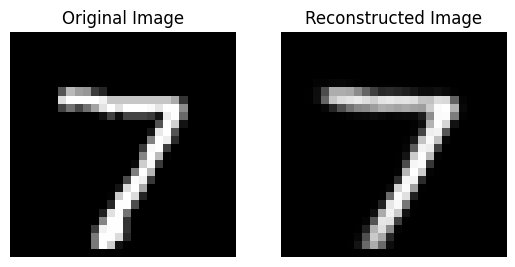

In [18]:
show_image(x, x_hat)

### 6. Generate image from noise vector

- Intractable한 Real Posterior $p_{\theta}(z|x)$를 몰라도, Tractable한 Gaussian Posterior Distribution $q_{\phi}(z|x)$을 이용하여 VAE 학습을 통해 Regularization Term $D_{KL}(q_{\phi}(z|x) \parallel p(z))$ 이 0으로 수렴하게 만든다.

- Gaussian Posterior Distribution $q_{\phi}(z|x)$이 Gaussian Prior $\mathcal{N}(0,I)$에 근접해지므로 Gaussian Noise $p(z)$로부터 바로 sampling하여 Image Generation이 가능하다. 
- 다만 너무 tight하게 $\mathcal{N}(0,I)$에 근접하게 할 경우 Posterior Collapse Problem이 발생하여 "enough"하게 근접시킨다.

In [19]:
with torch.no_grad():
    # input_dim -> latent_dim -> input_dim(=output_dim)
    noise = torch.randn(batch_size, latent_dim).to(device)
    samples = decoder(noise).view(-1, 1, 28, 28).cpu().numpy()

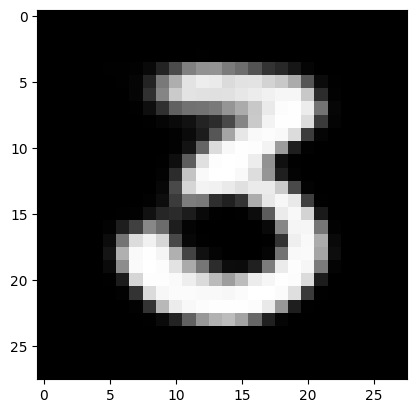

In [35]:
plt.imshow(samples[32][0], cmap="gray")
# samples: (batch_size, 1, 28, 28)
# first index: sample index (0 ~ batch_size-1)
# second index: channel index (only one channel in this case)

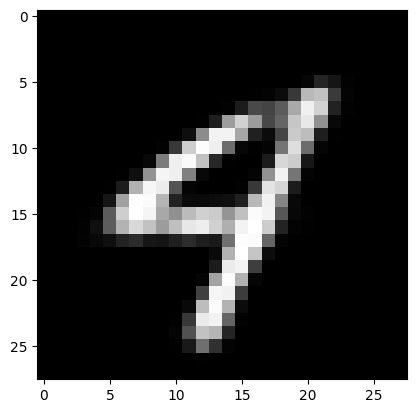

In [36]:
plt.imshow(samples[23][0], cmap="gray")